### Notebook Structure

The previous notebook, `examine_spike_sorting_results.ipynb`, was created for a general exploration of the pipeline results.

Given the presence of an artifact in the current pipeline results, this notebook focuses on filtering them based on quality metrics to identify waveform shapes without those oscillations.


In [13]:
import os

if os.path.basename(os.getcwd()) == "illustration":
    os.chdir("..")
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [14]:
import datajoint as dj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime

In [15]:
from workflow.pipeline import *

In [16]:
key_1 = {
    "organoid_id": "O10",
    "experiment_start_time": datetime.datetime(2023, 5, 18, 12, 25),
    "insertion_number": 0,
    "start_time": datetime.datetime(2023, 5, 18, 12, 54),
    "end_time": datetime.datetime(2023, 5, 18, 12, 59),
    "paramset_idx": 1,
}

These are all the available SpikeInterface quality metrics contained in both the `Cluster` and `Waveform` tables:


In [17]:
qm_query = ephys.QualityMetrics.Cluster * ephys.QualityMetrics.Waveform & key_1
qm_query

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,isi_violation rate of ISI violation as a fraction of overall rate,number_violation total number of ISI violations,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster,silhouette_score Standard metric for cluster overlap,max_drift Maximum change in spike depth throughout recording,cumulative_drift Cumulative change in spike depth throughout recording,contamination_rate,amplitude (uV) absolute difference between waveform peak and trough,duration (ms) time between waveform peak and trough,halfwidth (ms) spike width at half max amplitude,pt_ratio absolute amplitude of peak divided by absolute amplitude of trough relative to 0,repolarization_slope the repolarization slope was defined by fitting a regression line to the first 30us from trough to peak,recovery_slope the recovery slope was defined by fitting a regression line to the first 30us from peak to tail,spread (um) the range with amplitude above 12-percent of the maximum amplitude along the probe,velocity_above (s/m) inverse velocity of waveform propagation from the soma toward the top of the probe,velocity_below (s/m) inverse velocity of waveform propagation from the soma toward the bottom of the probe
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,0,59.1567,2.4226,1.0,0.508325,1601,0.000249838,nan,nan,nan,nan,nan,nan,0.0,0.0,1.0,-16.575,0.0009,0.000215,-0.381012,40799.4,-9621.34,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,1,48.1367,2.59133,1.0,0.6181,1289,0.000123436,84.3777,0.0439854,4.1625,0.935,0.0525,0.231045,0.0,0.0,1.0,-15.21,0.00077,0.000215,-0.242014,48320.2,-4665.99,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,2,143.517,2.51551,1.0,0.541502,10038,1.57141e-05,23.5781,0.283473,4.17605,0.84,0.0075,0.173947,0.0,0.0,1.0,-11.115,0.00068,0.00017,-0.182161,38803.6,-2349.58,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,3,62.5233,2.5549,1.0,0.556527,1958,4.96933e-05,99.8235,0.0381521,3.82519,0.9205,0.077,0.232229,0.0,0.0,1.0,-15.015,0.00079,0.000185,-0.248941,52809.6,-6359.83,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,4,57.0167,2.67701,1.0,0.542756,1588,4.56701e-05,124.757,0.0313973,4.13196,0.926,0.01,0.160009,0.0,0.0,1.0,-14.235,0.000575,0.000185,-0.233784,48096.5,-3249.89,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,5,62.84,2.85373,1.0,0.599047,2129,0.000151968,32.8741,0.152752,4.23301,0.8375,0.0045,0.181215,0.0,0.0,1.0,-13.455,0.00058,0.000175,-0.210654,54795.3,-3444.08,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,6,57.91,2.64897,1.0,0.496652,1499,0.03536,125.679,0.0214472,4.41776,0.9445,0.0375,0.252806,0.0,0.0,1.0,-11.895,0.000895,0.00022,-0.341398,29695.9,-4958.09,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,7,53.4933,2.55916,1.0,0.546327,1407,7.93495e-05,41.5531,0.0702365,4.55556,0.867,0.00625,0.194347,0.0,0.0,1.0,-13.26,0.00072,0.000165,-0.242507,41228.3,-4963.73,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,8,59.9767,2.5839,1.0,0.526026,1703,0.00056736,109.057,0.0326888,4.09896,0.935,0.0545,0.232034,0.0,0.0,1.0,-13.26,0.000715,0.000225,-0.307384,42993.7,-6334.77,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,9,56.52,2.6391,1.0,0.536685,1543,6.6082e-05,100.081,0.0332763,3.90499,0.933,0.077,0.236809,0.0,0.0,1.0

## Establishing threshold criteria: Initial setup for filtering metrics


The criteria presented in this notebook serves as an illustration of querying using one or more thresholds in the Quality Metrics.

The aim is to use this initial setup as a foundation for exploring additional criteria tailored to your specific experiments.


For example, unit restriction criteria based on brain regions could be implemented as follows:


In [18]:
brain_area_unit_restrictions = {
    "Medulla":
    # "amplitude > 150 "
    "firing_rate > 0.2 "
    "AND presence_ratio > 0.9 "
    "AND isi_violation < 10 "
    "AND amplitude_cutoff < 0.15",
    "ALM":
    # "amplitude > 100 "
    "firing_rate > 0.2 "
    "AND presence_ratio > 0.95 "
    "AND isi_violation < 0.1 "
    "AND amplitude_cutoff < 0.1",
    "Midbrain":
    # "amplitude > 100 "
    "firing_rate > 0.1 "
    "AND presence_ratio > 0.9 "
    "AND isi_violation < 1 "
    "AND amplitude_cutoff < 0.08",
    "Thalamus":
    # "amplitude > 90 "
    "firing_rate > 0.1 "
    "AND presence_ratio > 0.9 "
    "AND isi_violation < 0.05 "
    "AND amplitude_cutoff < 0.08",
    "Striatum":
    # "amplitude > 70 "
    "firing_rate > 0.1 "
    "AND presence_ratio > 0.9 "
    "AND isi_violation < 0.5 "
    "AND amplitude_cutoff < 0.1",
}

In [19]:
qm_query & brain_area_unit_restrictions["Medulla"]

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,isi_violation rate of ISI violation as a fraction of overall rate,number_violation total number of ISI violations,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster,silhouette_score Standard metric for cluster overlap,max_drift Maximum change in spike depth throughout recording,cumulative_drift Cumulative change in spike depth throughout recording,contamination_rate,amplitude (uV) absolute difference between waveform peak and trough,duration (ms) time between waveform peak and trough,halfwidth (ms) spike width at half max amplitude,pt_ratio absolute amplitude of peak divided by absolute amplitude of trough relative to 0,repolarization_slope the repolarization slope was defined by fitting a regression line to the first 30us from trough to peak,recovery_slope the recovery slope was defined by fitting a regression line to the first 30us from peak to tail,spread (um) the range with amplitude above 12-percent of the maximum amplitude along the probe,velocity_above (s/m) inverse velocity of waveform propagation from the soma toward the top of the probe,velocity_below (s/m) inverse velocity of waveform propagation from the soma toward the bottom of the probe
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,0,59.1567,2.4226,1.0,0.508325,1601,0.000249838,nan,nan,nan,nan,nan,nan,0.0,0.0,1.0,-16.575,0.0009,0.000215,-0.381012,40799.4,-9621.34,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,1,48.1367,2.59133,1.0,0.6181,1289,0.000123436,84.3777,0.0439854,4.1625,0.935,0.0525,0.231045,0.0,0.0,1.0,-15.21,0.00077,0.000215,-0.242014,48320.2,-4665.99,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,2,143.517,2.51551,1.0,0.541502,10038,1.57141e-05,23.5781,0.283473,4.17605,0.84,0.0075,0.173947,0.0,0.0,1.0,-11.115,0.00068,0.00017,-0.182161,38803.6,-2349.58,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,3,62.5233,2.5549,1.0,0.556527,1958,4.96933e-05,99.8235,0.0381521,3.82519,0.9205,0.077,0.232229,0.0,0.0,1.0,-15.015,0.00079,0.000185,-0.248941,52809.6,-6359.83,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,4,57.0167,2.67701,1.0,0.542756,1588,4.56701e-05,124.757,0.0313973,4.13196,0.926,0.01,0.160009,0.0,0.0,1.0,-14.235,0.000575,0.000185,-0.233784,48096.5,-3249.89,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,5,62.84,2.85373,1.0,0.599047,2129,0.000151968,32.8741,0.152752,4.23301,0.8375,0.0045,0.181215,0.0,0.0,1.0,-13.455,0.00058,0.000175,-0.210654,54795.3,-3444.08,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,6,57.91,2.64897,1.0,0.496652,1499,0.03536,125.679,0.0214472,4.41776,0.9445,0.0375,0.252806,0.0,0.0,1.0,-11.895,0.000895,0.00022,-0.341398,29695.9,-4958.09,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,7,53.4933,2.55916,1.0,0.546327,1407,7.93495e-05,41.5531,0.0702365,4.55556,0.867,0.00625,0.194347,0.0,0.0,1.0,-13.26,0.00072,0.000165,-0.242507,41228.3,-4963.73,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,8,59.9767,2.5839,1.0,0.526026,1703,0.00056736,109.057,0.0326888,4.09896,0.935,0.0545,0.232034,0.0,0.0,1.0,-13.26,0.000715,0.000225,-0.307384,42993.7,-6334.77,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,9,56.52,2.6391,1.0,0.536685,1543,6.6082e-05,100.081,0.0332763,3.90499,0.933,0.077,0.236809,0.0,0.0,1.0

In [20]:
qm_query & brain_area_unit_restrictions["ALM"]

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,isi_violation rate of ISI violation as a fraction of overall rate,number_violation total number of ISI violations,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster,silhouette_score Standard metric for cluster overlap,max_drift Maximum change in spike depth throughout recording,cumulative_drift Cumulative change in spike depth throughout recording,contamination_rate,amplitude (uV) absolute difference between waveform peak and trough,duration (ms) time between waveform peak and trough,halfwidth (ms) spike width at half max amplitude,pt_ratio absolute amplitude of peak divided by absolute amplitude of trough relative to 0,repolarization_slope the repolarization slope was defined by fitting a regression line to the first 30us from trough to peak,recovery_slope the recovery slope was defined by fitting a regression line to the first 30us from peak to tail,spread (um) the range with amplitude above 12-percent of the maximum amplitude along the probe,velocity_above (s/m) inverse velocity of waveform propagation from the soma toward the top of the probe,velocity_below (s/m) inverse velocity of waveform propagation from the soma toward the bottom of the probe


In [21]:
qm_query & brain_area_unit_restrictions["Midbrain"]

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,isi_violation rate of ISI violation as a fraction of overall rate,number_violation total number of ISI violations,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster,silhouette_score Standard metric for cluster overlap,max_drift Maximum change in spike depth throughout recording,cumulative_drift Cumulative change in spike depth throughout recording,contamination_rate,amplitude (uV) absolute difference between waveform peak and trough,duration (ms) time between waveform peak and trough,halfwidth (ms) spike width at half max amplitude,pt_ratio absolute amplitude of peak divided by absolute amplitude of trough relative to 0,repolarization_slope the repolarization slope was defined by fitting a regression line to the first 30us from trough to peak,recovery_slope the recovery slope was defined by fitting a regression line to the first 30us from peak to tail,spread (um) the range with amplitude above 12-percent of the maximum amplitude along the probe,velocity_above (s/m) inverse velocity of waveform propagation from the soma toward the top of the probe,velocity_below (s/m) inverse velocity of waveform propagation from the soma toward the bottom of the probe
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,0,59.1567,2.4226,1.0,0.508325,1601,0.000249838,nan,nan,nan,nan,nan,nan,0.0,0.0,1.0,-16.575,0.0009,0.000215,-0.381012,40799.4,-9621.34,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,1,48.1367,2.59133,1.0,0.6181,1289,0.000123436,84.3777,0.0439854,4.1625,0.935,0.0525,0.231045,0.0,0.0,1.0,-15.21,0.00077,0.000215,-0.242014,48320.2,-4665.99,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,2,143.517,2.51551,1.0,0.541502,10038,1.57141e-05,23.5781,0.283473,4.17605,0.84,0.0075,0.173947,0.0,0.0,1.0,-11.115,0.00068,0.00017,-0.182161,38803.6,-2349.58,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,3,62.5233,2.5549,1.0,0.556527,1958,4.96933e-05,99.8235,0.0381521,3.82519,0.9205,0.077,0.232229,0.0,0.0,1.0,-15.015,0.00079,0.000185,-0.248941,52809.6,-6359.83,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,4,57.0167,2.67701,1.0,0.542756,1588,4.56701e-05,124.757,0.0313973,4.13196,0.926,0.01,0.160009,0.0,0.0,1.0,-14.235,0.000575,0.000185,-0.233784,48096.5,-3249.89,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,5,62.84,2.85373,1.0,0.599047,2129,0.000151968,32.8741,0.152752,4.23301,0.8375,0.0045,0.181215,0.0,0.0,1.0,-13.455,0.00058,0.000175,-0.210654,54795.3,-3444.08,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,6,57.91,2.64897,1.0,0.496652,1499,0.03536,125.679,0.0214472,4.41776,0.9445,0.0375,0.252806,0.0,0.0,1.0,-11.895,0.000895,0.00022,-0.341398,29695.9,-4958.09,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,7,53.4933,2.55916,1.0,0.546327,1407,7.93495e-05,41.5531,0.0702365,4.55556,0.867,0.00625,0.194347,0.0,0.0,1.0,-13.26,0.00072,0.000165,-0.242507,41228.3,-4963.73,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,8,59.9767,2.5839,1.0,0.526026,1703,0.00056736,109.057,0.0326888,4.09896,0.935,0.0545,0.232034,0.0,0.0,1.0,-13.26,0.000715,0.000225,-0.307384,42993.7,-6334.77,0.0,nan,nan
O10,2023-05-18 12:25:00,0,2023-05-18 12:54:00,2023-05-18 12:59:00,1,9,56.52,2.6391,1.0,0.536685,1543,6.6082e-05,100.081,0.0332763,3.90499,0.933,0.077,0.236809,0.0,0.0,1.0

In [22]:
qm_query & brain_area_unit_restrictions["Thalamus"]

organoid_id e.g. O17,experiment_start_time,insertion_number,start_time,end_time,paramset_idx,unit,firing_rate (Hz) firing rate for a unit,snr signal-to-noise ratio for a unit,presence_ratio fraction of time in which spikes are present,isi_violation rate of ISI violation as a fraction of overall rate,number_violation total number of ISI violations,amplitude_cutoff estimate of miss rate based on amplitude histogram,isolation_distance distance to nearest cluster in Mahalanobis space,l_ratio,d_prime Classification accuracy based on LDA,nn_hit_rate Fraction of neighbors for target cluster that are also in target cluster,nn_miss_rate Fraction of neighbors outside target cluster that are in target cluster,silhouette_score Standard metric for cluster overlap,max_drift Maximum change in spike depth throughout recording,cumulative_drift Cumulative change in spike depth throughout recording,contamination_rate,amplitude (uV) absolute difference between waveform peak and trough,duration (ms) time between waveform peak and trough,halfwidth (ms) spike width at half max amplitude,pt_ratio absolute amplitude of peak divided by absolute amplitude of trough relative to 0,repolarization_slope the repolarization slope was defined by fitting a regression line to the first 30us from trough to peak,recovery_slope the recovery slope was defined by fitting a regression line to the first 30us from peak to tail,spread (um) the range with amplitude above 12-percent of the maximum amplitude along the probe,velocity_above (s/m) inverse velocity of waveform propagation from the soma toward the top of the probe,velocity_below (s/m) inverse velocity of waveform propagation from the soma toward the bottom of the probe


#### Exploration of a query from on of the previous quality metric filters


In [25]:
striatum_keys = (qm_query & brain_area_unit_restrictions["Striatum"]).fetch("KEY")

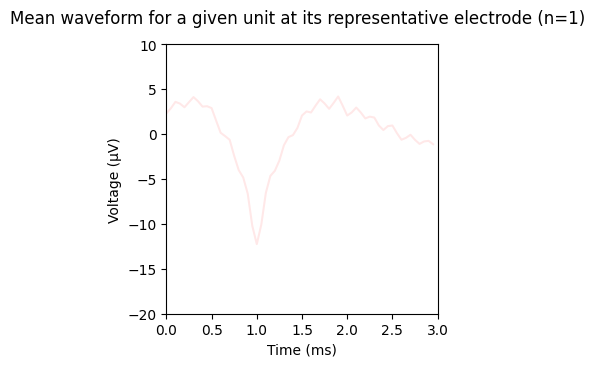

In [26]:
peak_wfs = (ephys.WaveformSet.PeakWaveform & striatum_keys).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & striatum_keys).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(striatum_keys)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

##


## Waverform post-analysis


### One criteria based on Cluster Quality Metrics


In [27]:
# Parameter Dictionaries
Batches = ["Batch 1", "Batch 2", "Batch 3"]
Drugs = ["4-AP", "No Drug", "Bicuculline", "Tetrodotoxin"]
Organoids = {
    "Batch 1": ["O09", "O10", "O11", "O12"],
    "Batch 2": ["O13", "O14", "O15", "O16"],
    "Batch 3": ["O17", "O18", "O19", "O20"],
}

In [30]:
# BATCH 1, DRUG 4-AP
org_keys_1 = (
    culture.Experiment * ephys.ClusteringTask
    & 'drug_name="4-AP"'
    & 'organoid_id="O09"'
    & "paramset_idx=1"
).fetch("KEY")
org_keys_2 = (
    culture.Experiment * ephys.ClusteringTask
    & 'drug_name="4-AP"'
    & 'organoid_id="O10"'
    & "paramset_idx=1"
).fetch("KEY")
org_keys_3 = (
    culture.Experiment * ephys.ClusteringTask
    & 'drug_name="4-AP"'
    & 'organoid_id="O11"'
    & "paramset_idx=1"
).fetch("KEY")
org_keys_4 = (
    culture.Experiment * ephys.ClusteringTask
    & 'drug_name="4-AP"'
    & 'organoid_id="O12"'
    & "paramset_idx=1"
).fetch("KEY")

batch_keys = [org_keys_1, org_keys_2, org_keys_3, org_keys_4]

In [31]:
cluster_query = ephys.QualityMetrics.Cluster & batch_keys
wf_query = ephys.QualityMetrics.Waveform & batch_keys

In [32]:
keys_raw = (ephys.QualityMetrics.Cluster & batch_keys).fetch("KEY")
len(keys_raw)

280

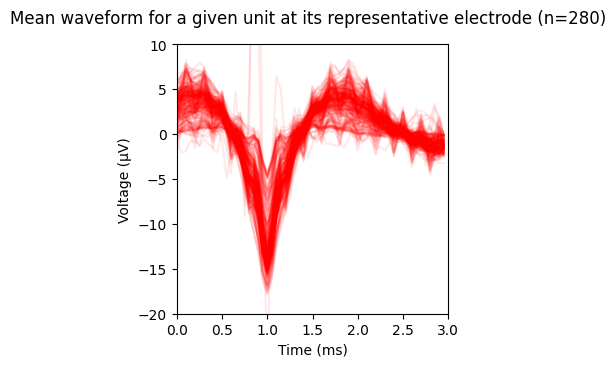

In [33]:
peak_wfs_raw = (ephys.WaveformSet.PeakWaveform & keys_raw).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & keys_raw[0]).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs_raw[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs_raw)):
    plt.plot(peak_wf_timestamps, peak_wfs_raw[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(peak_wfs_raw)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

Let's filter these units by the following QM criteria:


In [34]:
keys = (
    ephys.QualityMetrics.Cluster * ephys.QualityMetrics.Waveform
    & batch_keys
    & "presence_ratio > 0.9"
    & "pt_ratio > -0.4"
    & "isi_violation < 0.5"
    & "l_ratio < 0.2"
    & "halfwidth > 0.0002"  # 0.2 ms
).fetch("KEY")
len(keys)

83

In [35]:
keys = (ephys.WaveformSet.PeakWaveform & keys).fetch("KEY")
len(keys)

83

The result now consists of 83 units, down from the previous count of 280. Let's represent them:


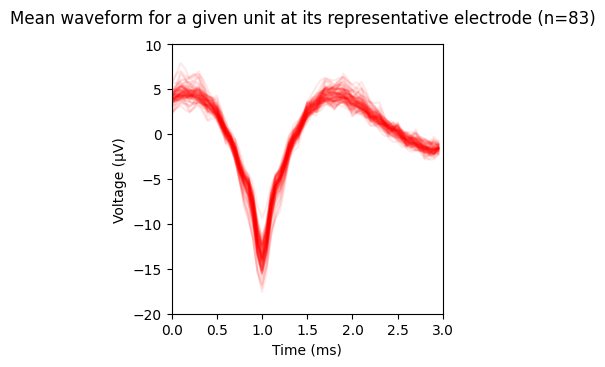

In [38]:
peak_wfs = (ephys.WaveformSet.PeakWaveform & keys).fetch("peak_electrode_waveform")
sample_rate = (ephys.EphysSessionInfo & keys[0]).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(peak_wfs)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

### Another criteria based on Waveform Quality Metrics


In [54]:
query_2 = wf_query & "amplitude >-20 <20" & "spread > 50" & "pt_ratio > -0.25"
len(query_2)

17

In [55]:
keys_wf_raw = (wf_query).fetch("KEY")
len(keys_wf_raw)

280

In [56]:
keys_wf_filtered = (query_2).fetch("KEY")
len(keys_wf_filtered)

17

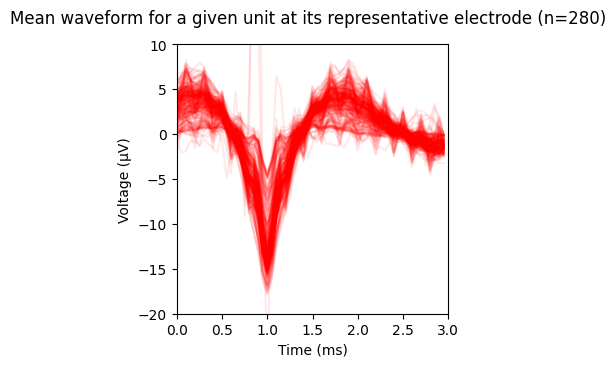

In [57]:
peak_wfs_raw = (ephys.WaveformSet.PeakWaveform & keys_wf_raw).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & keys_wf_raw[0]).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs_raw[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs_raw)):
    plt.plot(peak_wf_timestamps, peak_wfs_raw[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(peak_wfs_raw)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

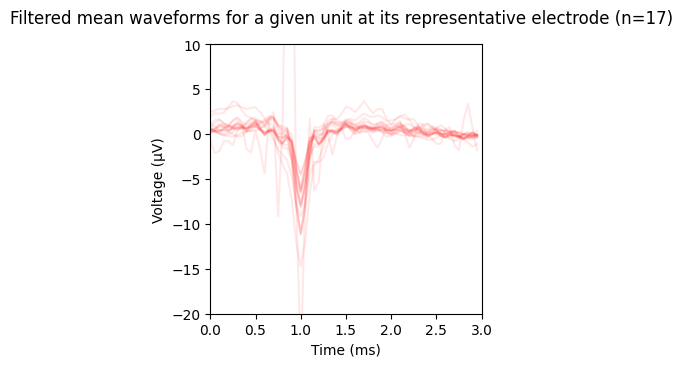

In [58]:
peak_wfs = (ephys.WaveformSet.PeakWaveform & keys_wf_filtered).fetch(
    "peak_electrode_waveform"
)
sample_rate = (ephys.EphysSessionInfo & keys_wf_filtered[0]).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Filtered mean waveforms for a given unit at its representative electrode (n={len(peak_wfs)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()

### Criteria derived from a combination of Cluster and Waveform Quality Metrics


In [60]:
keys = (
    ephys.QualityMetrics.Cluster * ephys.QualityMetrics.Waveform
    & batch_keys
    & "presence_ratio > 0.9"
    & "pt_ratio > -0.4"
    & "silhouette_score > 0.1"
    & "amplitude > -20 < 20"
    & "halfwidth > 0.0002"
    & "spread > 25"
).fetch("KEY")
len(keys)

11

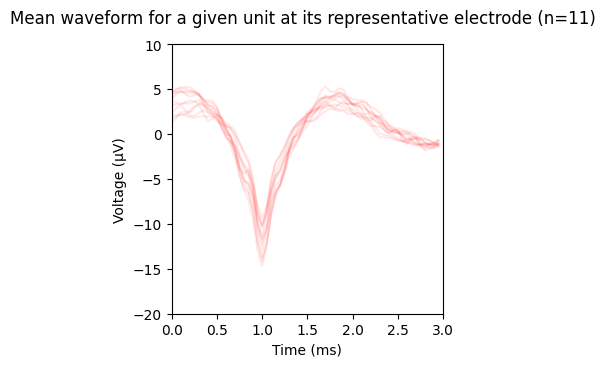

In [61]:
peak_wfs = (ephys.WaveformSet.PeakWaveform & keys).fetch("peak_electrode_waveform")
sample_rate = (ephys.EphysSessionInfo & keys[0]).fetch1("session_info")[
    "sample_rate"
] / 1e3  # sampling rate in kHz
peak_wf_timestamps = np.arange(len(peak_wfs[0])) / sample_rate  # ms

# plot waveforms
fig = plt.figure(figsize=(3.5, 3.5))
for idx in range(len(peak_wfs)):
    plt.plot(peak_wf_timestamps, peak_wfs[idx], color="red", alpha=0.09)
plt.suptitle(
    f"Mean waveform for a given unit at its representative electrode (n={len(peak_wfs)})"
)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.xlim(0, 3)
plt.ylim(-20, 10)
plt.show()